#--------------------------------------------- **第一區不可動,載入必要資料**--------------------------------------------------------------

In [114]:
import torchvision
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random


# **載入 CIFAR-10 數據集並提取狗與卡車影像**
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


airplane_images, ship_images = [], []
for img, label in trainset:
    if label == 5 and len(airplane_images) < 5000:
        airplane_images.append(img.numpy())
    elif label == 9 and len(ship_images) < 5000:
        ship_images.append(img.numpy())
    if len(airplane_images) >= 5000 and len(ship_images) >= 5000:
        break

images = np.concatenate((airplane_images, ship_images), axis=0)
labels = np.array([0] * 5000 + [1] * 5000)
print(images.shape, labels.shape)


(10000, 3, 32, 32) (10000,)


#------------------------------------- **第二區可動，以下為同學自行提取特徵features**------------------------------------------------------


In [115]:
def extract_features(image):

    #HOG
    #Tensor -> opencv
    img_np = image.transpose(1, 2, 0) # 轉為 HWC
    img_np = (img_np * 255).astype(np.uint8) # 轉為 0-255 整數
    
    # 2gray
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # HOGdescripter
    winSize = (32, 32)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (2, 2)
    nbins = 8
    
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    
    # compute
    hog_feats = hog.compute(gray).flatten()

    #HSV
    hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
    
    # 計算直方圖
    # H (色相) 分 30 等份, S (飽和度) 分 32 等份. V (亮度) 通常不重要，忽略
    h_hist = cv2.calcHist([hsv], [0], None, [30], [0, 180])
    s_hist = cv2.calcHist([hsv], [1], None, [32], [0, 256])
    
    # 歸一化 (Normalize): 讓色彩特徵的數值範圍跟 HOG 差不多 (0~1之間)
    # 這是 K-Means 能否成功的關鍵！
    cv2.normalize(h_hist, h_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(s_hist, s_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
    color_feats = np.concatenate([h_hist.flatten(), s_hist.flatten()])

    final_feature = np.concatenate([hog_feats, color_feats*0.5])

    return final_feature

print("正在提取HOG+HSV特徵...")
# 提取所有影像的特徵
features = np.array([extract_features(img) for img in images])





正在提取HOG+HSV特徵...


#--------------------------------------- **第三區不可動,將features丟進Kmeans裡面**--------------------------------------------------------

K-means Clustering Accuracy: 85.58%


<Figure size 800x600 with 0 Axes>

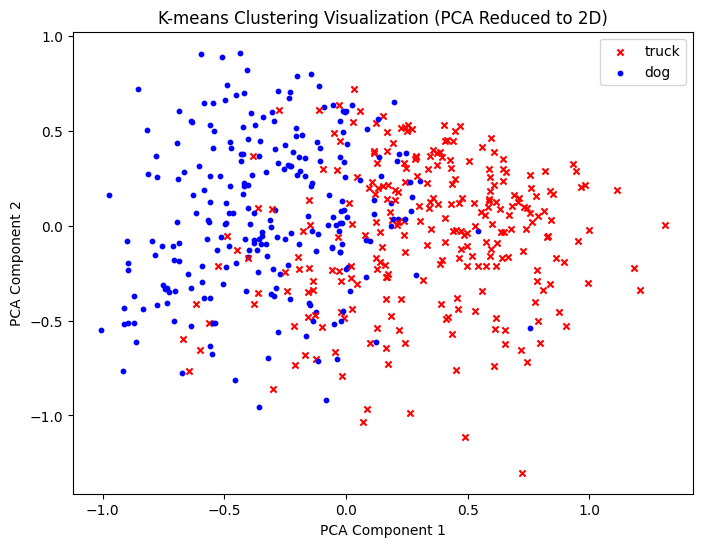

In [116]:
# **K-means 聚類**
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features)
predicted_labels = kmeans.labels_

# 修正標籤與計算準確度
if np.mean(predicted_labels[:5000]) > 0.5:
    predicted_labels = 1 - predicted_labels
accuracy = accuracy_score(labels, predicted_labels)
print(f"K-means Clustering Accuracy: {accuracy * 100:.2f}%")
# **降維 (PCA)**
pca = PCA(n_components=2)  # 將特徵降維到 2 維
features_2d = pca.fit_transform(features)

# **繪製分群結果，藍色圓圈與紅色叉叉，並添加圖例**
plt.figure(figsize=(8, 6))

# 隨機選取 100 個點的索引
sample_indices = random.sample(range(features_2d.shape[0]), 500)

# **繪製分群結果，藍色圓圈與紅色叉叉，並添加圖例**
plt.figure(figsize=(8, 6))

for i in sample_indices:
    if labels[i] == 0:
        plt.scatter(features_2d[i, 0], features_2d[i, 1], color='blue', marker='o', s=10, label='dog' if 'dog' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(features_2d[i, 0], features_2d[i, 1], color='red', marker='x', s=20, label='truck' if 'truck' not in plt.gca().get_legend_handles_labels()[1] else "")

# 添加圖例，避免重複顯示
plt.legend(loc='best')
plt.title("K-means Clustering Visualization (PCA Reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()